# Data Cleaning using U.S. Census Data

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob


## Import Data and Inspect it

In [2]:
files = glob.glob('states*.csv') #gather multiple state files into one list of data
df_list = []
for file in files:
  data = pd.read_csv(file)
  df_list.append(data)
us_census = pd.concat(df_list)

print(us_census.head()) #inspect first 5 rows of table
print(us_census.info())
#print(len(us_census)) # find number of entries in table
#print(us_census.columns) #get column labels

# print the first 10 rows in state to detect issue
print(us_census['State'][:10])


   Unnamed: 0       State  TotalPop             Hispanic                White  \
0           0     Alabama   4830620  3.7516156462584975%     61.878656462585%   
1           1      Alaska    733375   5.909580838323351%  60.910179640718574%   
2           2     Arizona   6641928  29.565921052631502%  57.120000000000026%   
3           3    Arkansas   2958208   6.215474452554738%   71.13781021897813%   
4           4  California  38421464  37.291874687968054%   40.21578881677474%   

                 Black                Native                Asian  \
0   31.25297619047618%   0.4532312925170065%  1.0502551020408146%   
1  2.8485029940119775%    16.39101796407186%   5.450299401197604%   
2  3.8509868421052658%     4.35506578947368%   2.876578947368419%   
3  18.968759124087573%   0.5229197080291965%  1.1423357664233578%   
4   5.677396405391911%  0.40529206190713685%  13.052234148776776%   

                Pacific              Income            GenderPop  
0  0.03435374149659865%  $43296

The combined dataframe has 11 columns and 60 rows on race/ethnicity populations in each state.  As this is data for states in the US, we know there is something wrong with the data if we have 60 entries for states and not 51 (the data includes Washington DC).  Looking at the state column we can see we have some repeated values that are causing this issue.  Also, the data types for some of the numerical columns are not in numerical formats and Gender and Population are combined into one column called "GenderPop"

## Let's start with the income column

In [3]:
# Convert income column to numeric
us_census["Income"] = pd.to_numeric(us_census["Income"].str.strip("($)")) #must remove the $ before converting it

## Next let's split the GenderPop column into 2 columns

In [4]:
# The genders are split by _
gender_pop = us_census["GenderPop"]
gender_pop_split = gender_pop.str.split("_")
#The first gender is Male the second Female
us_census["Men"] = gender_pop_split.str[0]
us_census["Men"] = us_census.Men.str.replace("M", "") #get rid of the Male tag
us_census["Women"] = gender_pop_split.str[1]
us_census["Women"] = us_census.Women.str.replace("F", "") #get rid of the Female tag

# Convert these newly cleaned columns to numeric
us_census.Men = pd.to_numeric(us_census.Men)
us_census.Women = pd.to_numeric(us_census.Women)

# Some of the women data is missing, but we can use the total and the men data to fill it
us_census.Women = us_census.Women.fillna(us_census.TotalPop - us_census.Men)
# Rearrange order of the columns for clearer reading
us_census = us_census[['State', 'TotalPop', 'Women', 'Men', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income']]
print(us_census.head())

        State  TotalPop       Women       Men             Hispanic  \
0     Alabama   4830620   2489527.0   2341093  3.7516156462584975%   
1      Alaska    733375    349215.0    384160   5.909580838323351%   
2     Arizona   6641928   3342840.0   3299088  29.565921052631502%   
3    Arkansas   2958208   1506295.0   1451913   6.215474452554738%   
4  California  38421464  19334329.0  19087135  37.291874687968054%   

                 White                Black                Native  \
0     61.878656462585%   31.25297619047618%   0.4532312925170065%   
1  60.910179640718574%  2.8485029940119775%    16.39101796407186%   
2  57.120000000000026%  3.8509868421052658%     4.35506578947368%   
3   71.13781021897813%  18.968759124087573%   0.5229197080291965%   
4   40.21578881677474%   5.677396405391911%  0.40529206190713685%   

                 Asian               Pacific        Income  
0  1.0502551020408146%  0.03435374149659865%  43296.358603  
1   5.450299401197604%   1.058682634730537

We know have a Women and Men column for their respective populations.

## Next let's remove duplicates from the data

In [5]:
# Inspect Duplicates
#print(us_census.sort_values(by = ['State']))

# Drop duplicates by state
us_census = us_census.drop_duplicates(subset=["State"])
duplicates = us_census.duplicated(subset=["State"])
print(duplicates.value_counts())

False    51
dtype: int64


We know have the desired amount of unique entries, 51.

## Now let's work on the remaining columns

In [6]:
## Clean % from columns
us_census.Hispanic = us_census.Hispanic.str.replace("%", "")
us_census.Hispanic = pd.to_numeric(us_census.Hispanic)
us_census.White = us_census.White.str.replace("%", "")
us_census.White = pd.to_numeric(us_census.White)
us_census.Black = us_census.Black.str.replace("%", "")
us_census.Black = pd.to_numeric(us_census.Black)
us_census.Native = us_census.Native.str.replace("%", "")
us_census.Native = pd.to_numeric(us_census.Native)
us_census.Asian = us_census.Asian.str.replace("%", "")
us_census.Asian = pd.to_numeric(us_census.Asian)
us_census.Pacific = us_census.Pacific.str.replace("%", "")
us_census.Pacific = pd.to_numeric(us_census.Pacific)

# Fill the missing data in Pacific with the remaining percent missing
us_census.Pacific = us_census.Pacific.fillna(100 - (us_census.Hispanic + us_census.White + us_census.Black + us_census.Native + us_census.Asian))


In [7]:
## Check the data is now clean and formatted as we want it
print(us_census.head())
print(us_census.dtypes)

        State  TotalPop       Women       Men   Hispanic      White  \
0     Alabama   4830620   2489527.0   2341093   3.751616  61.878656   
1      Alaska    733375    349215.0    384160   5.909581  60.910180   
2     Arizona   6641928   3342840.0   3299088  29.565921  57.120000   
3    Arkansas   2958208   1506295.0   1451913   6.215474  71.137810   
4  California  38421464  19334329.0  19087135  37.291875  40.215789   

       Black     Native      Asian   Pacific        Income  
0  31.252976   0.453231   1.050255  0.034354  43296.358603  
1   2.848503  16.391018   5.450299  1.058683  70354.743902  
2   3.850987   4.355066   2.876579  0.167632  54207.820955  
3  18.968759   0.522920   1.142336  0.146861  41935.633968  
4   5.677396   0.405292  13.052234  0.351410  67264.782303  
State        object
TotalPop      int64
Women       float64
Men           int64
Hispanic    float64
White       float64
Black       float64
Native      float64
Asian       float64
Pacific     float64
Income 

## Now that the data is clean we can make some visualizations with it

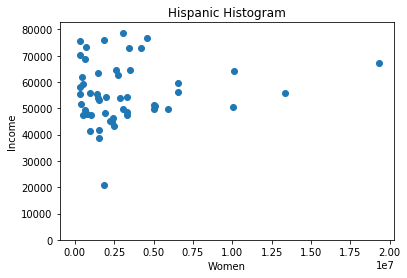

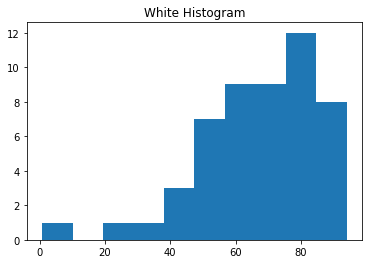

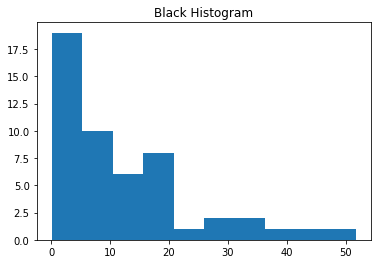

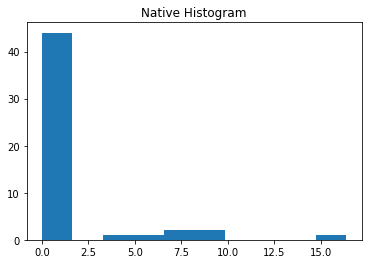

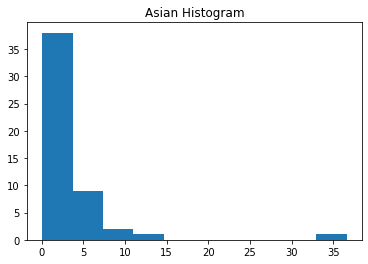

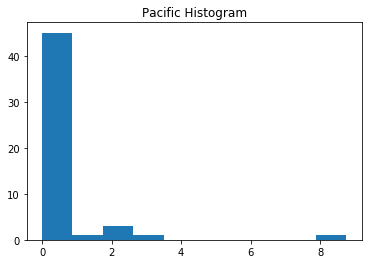

In [8]:
demographics = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']

plt.scatter(us_census.Women, us_census.Income)
plt.title("Scatter Plot of Women Income")
plt.xlabel("Women")
plt.ylabel("Income")

plt.hist(us_census.Hispanic)
plt.title("Hispanic Histogram")
plt.show()

plt.hist(us_census.White)
plt.title("White Histogram")
plt.show()

plt.hist(us_census.Black)
plt.title("Black Histogram")
plt.show()

plt.hist(us_census.Native)
plt.title("Native Histogram")
plt.show()

plt.hist(us_census.Asian)
plt.title("Asian Histogram")
plt.show()

plt.hist(us_census.Pacific)
plt.title("Pacific Histogram")
plt.show()